ResNet50 model 

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import numpy as np 
import pandas as pd 
import torch 
from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from PIL import Image
import torchvision
from torchvision.models.resnet import resnet50
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    torch.cuda.empty_cache()

In [2]:
import art
from art import attacks 
from art.attacks.evasion import DeepFool, CarliniL0Method, BasicIterativeMethod, CarliniL2Method
from art.estimators.classification import PyTorchClassifier

In [3]:
device

device(type='cuda')

In [4]:
# defining hyperparameters  
epochs = 3  #the nn will train 29 times 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [5]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees = (0,1))  

])

In [6]:
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [7]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    global base_dataset 
    base_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'train', transform=transforms, download=True)

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset, train_dataset
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f72f7c42b80>, <torch.utils.data.dataloader.DataLoader object at 0x7f720bd06fd0>)


In [8]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [9]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [10]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [11]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [12]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [13]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

model = model.to(device)

In [14]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


15:51:08 --- Epoch: 0	Train loss: 2.6637	Valid loss: 1.6539	Train accuracy: 54.07	Valid accuracy: 50.54
15:51:40 --- Epoch: 1	Train loss: 1.0911	Valid loss: 0.6402	Train accuracy: 86.13	Valid accuracy: 80.24
15:52:13 --- Epoch: 2	Train loss: 0.3680	Valid loss: 0.3263	Train accuracy: 95.62	Valid accuracy: 89.66


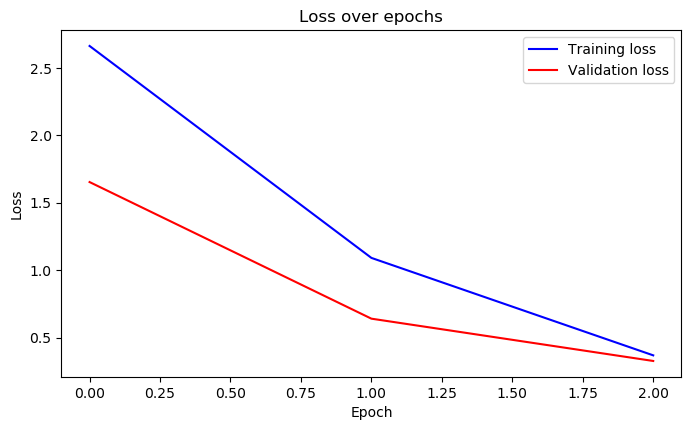

In [15]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [ ]:
torch.save(model.state_dict(), "resnet50.pt")

# CW attack 

In [16]:
# Weet je nog waarom we de layers hieronder hebben aangepast?
# model = resnet50(pretrained=False)
# model.fc = torch.nn.Linear(2048, 43)
# model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=5, stride=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# We wrap our model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)


In [17]:
plot_output = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1, verbose = False)
    success_rates = []
    for j, (image, true_label) in enumerate(test_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j > 100:
            break
    ASR = success_rates.count(True) / len(success_rates)
    accuracy_score = (1-ASR) 
    plot_output.append((i, accuracy_score))
# Plot output should contain our X, y coordinates. List[(x, y), (x, y), ...]
print("Average Success Rate: {:.2f}%".format(ASR), plot_output)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
x = [p[0] for p in plot_output]
y = [p[1] for p in plot_output]
# Plot the success rate over
plt.plot(x, y, label = "ASR")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('IFGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.plot(x, y, label = "ASR")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('IFGSM Attack Success Rate')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from art.defences.trainer import AdversarialTrainer

In [ ]:
adv_trainer = AdversarialTrainer(classifier= classifier, attacks = attack, ratio=0.5)

In [ ]:
for j, (image, true_label) in enumerate(train_dataset):
    # image is an image,
    # true_label is a simple int
    # Add batch dimension
    image = torch.unsqueeze(image, dim=0) # shape == [1, 3, 32, 32]
    image_numpy = image.numpy()
    true_label_numpy = np.array([true_label])
    # Generate adversarial sample
    adv_trainer_fit = adv_trainer.fit(image_numpy, true_label_numpy, batch = 64, nb_epochs = 30) # shape == [1, 3, 32, 32]


In [ ]:
# define your train and test dataset loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# define a function to train the model
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = (100 * correct / total)
    return train_loss, train_acc

# define a function to test the model
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = (100 * correct / total)
    return test_loss, test_acc

# initialize the model, criterion, and optimizer
model = resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize the PyTorchClassifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)

# Define an attack
attack = BasicIterativeMethod(estimator=classifier, max_iter=10, batch_size=1)

# adversarial training 
for j, (image, true_label) in enumerate(train_dataset):
    # image is an image,
    # true_label is a simple int
    # Add batch dimension
    image = torch.unsqueeze(image, dim=0) # shape == [1, 3, 32, 32]
    image_numpy = image.numpy()
    true_label_numpy = np.array([true_label])
    # Generate adversarial sample
    X_adv = attack.generate(image_numpy) # shape == [1, 3, 32, 32]
    # Normal prediction
    normal_prediction = torch.argmax(model(image)).item()
    # Prediction of the adversarial sample
    adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
    if normal_prediction != true_label:
        print(f"Original image was misclassified with true label: {true_label} and predicted label: {normal_prediction}")
    if adversarial_prediction != true_label:
        print(f"Adversarial image was misclassified with true label: {true_label} and predicted label: {adversarial_prediction}")
    if j > 100: 
        break

In [ ]:
# x_adv = np.concatenate((image_numpy, X_adv))
x_adv = [image, X_adv]
# y_adv = np.concatenate((true_label_numpy, true_label_numpy))
y_adv = np.array([true_label, true_label])
y_adv = torch.from_numpy(y_adv)
# y_adv = torch.from_numpy(y_adv)
classifier.fit(x_adv, y_adv, nb_epochs=1, batch_size=1)

torch.save(model, "resnet50_adv_trained.pt")

In [ ]:
# adversarial training iterations = 10
# For each number of iterations [1, 2, ..., 10], calculate the success rate/accuracy -> these are the X and Y coordinates of the graph
attack = BasicIterativeMethod(estimator=classifier, max_iter=10, batch_size=1)
for j, (image, true_label) in enumerate(train_dataset):
        # image is an image, given as a tensor with shape [3, 32, 32]
        # true_label is a simple int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        # normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        # adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()

        x_adv = np.concatenate((image, X_adv))
        y_adv = np.concatenate((true_label_numpy, true_label_numpy))
        y_adv = torch.from_numpy(y_adv)
        y_adv = y_adv.cpu()
        y_adv = y_adv.numpy()
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        # normal_prediction = torch.argmax(model(image)).item()


        classifier.fit(x_adv, y_adv, nb_epochs=1, batch_size=1)
        if j >= 10:
            break
torch.save(model, "resnet50_adv_trained.pt")


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# We wrap our model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    # model=WrappedModel(),
    model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
)

In [ ]:
import torch

# Load the model
model = torch.load("path/to/saved/model.pt")

# Evaluate the model on a dataset
outputs = model(x_test)
predictions = torch.argmax(outputs, dim=1)
accuracy = torch.mean((predictions == y_test).float())
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
# adversarial training 

plot_output = []
iterations = 10

# For each number of iterations [1, 2, ..., 10], calculate the success rate/accuracy -> these are the X and Y coordinates of the graph
for i in range(iterations):
    # Define an attack that only runs until this max iteration
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1)
    success_rates = []
    for j, (image, true_label) in enumerate(train_dataset):
        # image is an image, given as a tensor with shape [3, 32, 32]
        # true_label is a simple int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        x_adv = np.concatenate((image_numpy, X_adv))
        y_adv = np.concatenate((true_label_numpy, true_label_numpy))
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        # normal_prediction = torch.argmax(model(image)).item()

        classifier.fit(x_adv, y_adv, nb_epochs=1, batch_size=1)
        if j >= 10:
            break
classifier.save("resnet50_trained.pt")

In [ ]:
x = [p[0] for p in plot_output]
y = [p[1] for p in plot_output]
# Plot the success rate over
plt.plot(x,y)
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title(' BIM Attack Success Rate')
plt.show()

In [ ]:
plot_output = []
iterations = 10
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    # attack = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1)
    attack = BasicIterativeMethod(estimator=classifier, max_iter=i, batch_size=1)
    success_rates = []
    for j, (image, true_label) in enumerate(train_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack.generate(image_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            success_rates.append(True)
        else:
            success_rates.append(False)
        # success_rates.append(success)
        if j >= 10:
            break
    accuracy_score = success_rates.count(True) / len(success_rates)
    plot_output.append((i, accuracy_score))
# Plot output zou onze X, y coordinaten moeten bevatten. List[(x, y), (x, y), ...]
print(plot_output)

In [ ]:
# x = [p[0] for p in plot_output]
# y = [p[1] for p in plot_output]
# Plot the success rate over
plt.plot(x_coords, y_coords)
plt.xlabel('Iteration')
plt.ylabel('Accuracy score')
plt.title('CW Attack Success Rate')
plt.show()

In [ ]:
attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    success_rates = []
    for j, (image, true_label) in enumerate(train_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack_cw.generate(image_numpy, true_label_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            correct += 0
        # success_rates.append(success)

        if j >= 10: 
            break
    accuracy_score = correct / float(len(train_loader))
    plot_output.append((i, accuracy_score))
# Plot output zou onze X, y coordinaten moeten bevatten. List[(x, y), (x, y), ...]
print(plot_output)

In [ ]:
for i in range(iterations):
        correct = 0
        plot_output = []
        attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)

        for j, (image, true_label) in enumerate(test_dataset):
                if j <= 5:
                        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
                        image_numpy = image.numpy()
                        true_label_numpy = np.array([true_label])
                        X_adv = attack_cw.generate(image_numpy, true_label_numpy)  # shape == [1, 3, 32, 32]
                        normal_prediction = torch.argmax(model(image)).item()
                        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
                        if normal_prediction == true_label and adversarial_prediction != true_label:
                                correct += 1
        
        accuracy_score = correct / float(len(test_loader))
        plot_output.append((i, accuracy_score))

# Plot output zou onze X, y coordinaten moeten bevatten. List[(x, y), (x, y), ...]
print(plot_output, accuracy_score )

In [ ]:
plot_output = []
iterations = 3
correct = 0
# Voor elke hoeveelheid iteraties [1, 2, ..., 50], bereken de success rate/accuracy -> Dit zijn de X en Y coordinaten van de grafiek
for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    success_rates = []
    for j, (image, true_label) in enumerate(train_dataset):
        # image is een afbeelding. wordt gegeven als tensor met shape [3, 32, 32]
        # true_label is een simpele int
        # Add batch dimension
        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
        # Omvormen naar numpy array
        image_numpy = image.numpy()
        true_label_numpy = np.array([true_label])
        # Genereer adversarial sample
        X_adv = attack_cw.generate(image_numpy, true_label_numpy)  # shape == [1, 3, 32, 32]
        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
        normal_prediction = torch.argmax(model(image)).item()
        # Prediction van de adversarial sample
        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
        # Is de adversarial attack successvol of niet?
        # Hoe definieer je een successvolle aanval?
        # De definitie vanonder is gewoon een voorbeeld
        if normal_prediction == true_label and normal_prediction != adversarial_prediction:
            correct += 0
        # success_rates.append(success)

        if j >= 10: 
            break
    accuracy_score = correct / float(len(train_loader))
    plot_output.append((i, accuracy_score))
# Plot output zou onze X, y coordinaten moeten bevatten. List[(x, y), (x, y), ...]
print(plot_output)

In [ ]:
for i in range(iterations):
    for j, (image, true_label) in enumerate(test_dataset):
            success_rates = []
        
            attack_cw = CarliniL0Method(classifier=classifier, max_iter=5, batch_size=1, learning_rate=0.01)
            image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
            # Omvormen naar numpy array
            image_numpy = image.numpy()
            true_label_numpy = np.array([true_label])
            normal_prediction = torch.argmax(model(image)).item()
            # Genereer adversarial sample
            X_adv = attack_cw.generate(image_numpy, true_label_numpy)   
            adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
            success = adversarial_prediction != true_label_numpy
            success_rates.append(success)
            if j >= 5:
                break
    accuracy_score = ((1- success) / len(true_label_numpy))
    plot_output.append((i, accuracy_score))

    print(X_adv, plot_output)

In [ ]:
from art.utils import compute_accuracy, compute_success_array, compute_success   # 

In [ ]:

# https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/utils.html#art.utils.compute_accuracy

for i in range(iterations):
    # Define een attack die alleen runt tot deze max iterations!
    # Batch size is 1 omdat we hieronder ook over de dataset itereren in batches van 1
    attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
    success_rates = []
    for j, (image, true_label) in enumerate(train_dataset):
                if j <= 5:
                    image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
                    # Omvormen naar numpy array
                    image_numpy = image.numpy()
                    true_label_numpy = np.array([true_label])
                    # Genereer adversarial sample
                    X_adv = attack_cw.generate(image_numpy, true_label_numpy)  # shape == [1, 3, 32, 32]
                    normal_prediction = torch.argmax(model(image)).item()
                    # Prediction v/d adversarial sample
                    adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()

                    # success = normal_prediction == true_label and normal_prediction != adversarial_prediction
                    

                    # success_rates.append(success)
    # accuracy_score = success_rates.count(True) / len(success_rates)
    accuracy_score = compute_accuracy(preds = adversarial_prediction,  labels = normal_prediction, abstain = True)
    plot_output.append((i, accuracy_score))
# Plot output zou onze X, y coordinaten moeten bevatten. List[(x, y), (x, y), ...]
print(plot_output)

In [ ]:
for i in range(iterations):
        success_rates = []
        plot_output = []
        for j, (image, true_label) in enumerate(train_dataset):
                if j <= 5:
                        attack_cw = CarliniL0Method(classifier=classifier, max_iter=i, batch_size=1, learning_rate=0.01)
                        image = torch.unsqueeze(image, dim=0)  # shape == [1, 3, 32, 32]
                        # Omvormen naar numpy array
                        image_numpy = image.numpy()
                        true_label_numpy = np.array([true_label])
                        # Genereer adversarial sample
                        X_adv = attack_cw.generate(image_numpy, true_label_numpy)  # shape == [1, 3, 32, 32]
                        # Model prediction op de gewone image. Deze kan ook fout zijn ten opzichte van het echte label!
                        normal_prediction = model(image)
                        # Prediction van de adversarial sample
                        adversarial_prediction = torch.argmax(model(torch.from_numpy(X_adv))).item()
                        # De definitie vanonder is gewoon een voorbeeld
                        accuracy_score = compute_success(classifier = classifier, x_clean = image_numpy, labels = true_label_numpy, x_adv = X_adv, targeted = False, batch_size= 1 )

        plot_output.append((i, accuracy_score))

# Plot output zou onze X, y coordinaten moeten bevatten. List[(x, y), (x, y), ...]
print(plot_output, accuracy_score )

In [ ]:
# Evaluate the CW attack on the model
plot_output = cw_attack(iterations = 10)

In [ ]:
import matplotlib.pyplot as plt
# Plot the success rate over iterations
x = [p[0] for p in plot_output]
y = [p[1] for p in plot_output]
# Plot the success rate over
plt.plot(x, y)
plt.xlabel('Iteration')
plt.ylabel('Accuracy score')
plt.title('CW Attack Success Rate')
plt.show()

# IFGSM attack 

# IFGSM adversarial training 

# evaluation 

In [ ]:
parameters = (sum(p.numel() for p in model.parameters()))
parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

In [ ]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 



In [ ]:
model.to('cpu')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classes
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (40,15))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# print(cf_matrix)
# cf_report = classification_report(y_true, y_pred)
# print(cf_report)

In [ ]:
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report


get_classification_report(y_test = y_true, y_pred = y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))
print('Micro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))
print('Macro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))
print('Weighted Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='weighted')))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')

In [ ]:
print(cf_matrix)

In [ ]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('Resnet50.png')

In [ ]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    classes = []
    plotMat = []

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred) 


# FGSM Attack 

In [ ]:
X, y = test_dataset[0]
X.shape, X.min(), X.max()

# class NormalizeInverse(torchvision.transforms.Normalize):
#     """
#     Undoes the normalization and returns the reconstructed images in the input domain.
#     """

#     def __init__(self, mean, std):
#         mean = torch.as_tensor(mean)
#         std = torch.as_tensor(std)
#         std_inv = 1 / (std + 1e-7)
#         mean_inv = -mean * std_inv
#         super().__init__(mean=mean_inv, std=std_inv)

#     def __call__(self, tensor):
#         return super().__call__(tensor.clone())


# inverse_normalize = NormalizeInverse(mean=(0.3403, 0.3121, 0.3214), std=(0.2724, 0.2608, 0.2669))  # Same mean and std values as defined in the original transforms.
# #torchvision.transforms.ToPILImage()((X))

class WrappedModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.trained_model = model  # "model" is our trained model
    self.trained_model.to("cpu")
    self.normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))

  def forward(self, x: torch.Tensor):
    # x comes in as a Tensor of shape [3, 32, 32]
    # Manually add a batch dimension
    x = torch.unsqueeze(x, dim=0)
    # Shape of x is now [1, 3, 32, 32]
    # Normalize the input
    x_normalized = self.normalize(x)
    # Return only the logits
    logits = self.trained_model(x_normalized)
    return logits

# We again wrap our (already wrapped) model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
      model=WrappedModel(),
      clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
      loss=criterion,  # defined above
      optimizer=optimizer,  # defined above
      input_shape=(3, 32, 32),
      nb_classes=43,
      device_type="cpu"
)

attack = FastGradientMethod(estimator=classifier, eps=0.1)
# benign_x = inverse_normalize(X)
benign_x = X.cpu().numpy()  # convert torch to numpy
type(benign_x), benign_x.min(), benign_x.max()
x_adversarial = attack.generate(benign_x)

In [ ]:
import os 
#path = "/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm"
#os.mkdir(path)
test_model = WrappedModel()
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_adv = []
for i, (x, y_true) in enumerate(test_dataset):
    benign_x = x.cpu().numpy()
    y_predicted = torch.argmax(test_model(torch.Tensor(benign_x)))
    if y_predicted == y_true:
        x_adversarial = attack.generate(benign_x)
        y_adversarial = torch.argmax(test_model(torch.Tensor(x_adversarial)))
        if y_adversarial != y_predicted:
            x_adv.append(x_adversarial)
    if i > 100:
                    break


In [ ]:
print(x_adv)

# CW Attack

In [ ]:
from art.attacks.evasion import CarliniL0Method, CarliniL2Method, CarliniLInfMethod
from torchvision.datasets import GTSRB
from art.estimators.classification import PyTorchClassifier

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.trained_model = model  # "model" is our trained model
        self.trained_model.to("cpu")
        self.normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
    def forward(self, x: torch.Tensor):
        # x comes in as a Tensor of shape [1, 3, 32, 32] (same as the input size passed to attack.generate())
        # Normalize the input
        x_normalized = self.normalize(x)
        # Return only the logits
        logits = self.trained_model(x_normalized)
        return logits


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
wrapped_model = WrappedModel(model)
normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
# We again wrap our (already wrapped) model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    model=wrapped_model,
    # model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
    channels_first=True,
)
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor()]
)

test_dataset = GTSRB(root="data", split="test", transform=transforms, download=True)
x, y_true = test_dataset[0]
# cw0_attack = CarliniL0Method(classifier, learning_rate=0.0001)
# l2_attack = CarliniL2Method(classifier, learning_rate=0.0001)
# linf_attack = CarliniLInfMethod(classifier, learning_rate=0.0001)
# art_input = np.expand_dims(x.numpy(), axis=0)
# adv_samples = cw0_attack.generate(art_input)
# adv_samples = l2_attack.generate(art_input)
# adv_samples = linf_attack.generate(art_input)


In [ ]:
tested_model = wrapped_model.to('cpu')
tested_model

In [ ]:
import os 
path = "/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm"
os.mkdir(path)
for i, (x, y_true) in enumerate(test_dataset):
    attack = FastGradientMethod(estimator=classifier, eps=0.1)
    benign_x = x.cpu().numpy()
    test_model = WrappedModel()
    y_predicted = torch.argmax(test_model(torch.Tensor(benign_x)))
    #type(benign_x), benign_x.min(), benign_x.max()
    if y_predicted == y_true:
        x_adversarial = attack.generate(benign_x)
        y_adversarial = torch.argmax(test_model(torch.Tensor(x_adversarial)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_fgsm_sample_{i}", x_adversarial)
    else:
        print('failed')

In [ ]:
#path = "/volumes1/thesis/data/gtsrb/adv_samples_resnet50_l2"
#os.mkdir(path)
l2_attack = CarliniL2Method(classifier, learning_rate=0.0001)
for i, (x, y_true) in enumerate(test_dataset):
    art_input = np.expand_dims(x.numpy(), axis=0)
    y_predicted = torch.argmax(tested_model(torch.Tensor(art_input)))
    if y_predicted == y_true:
        adv_samples = l2_attack.generate(art_input) 
        y_adversarial = torch.argmax(tested_model(torch.Tensor(adv_samples)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_l2_sample_{i}", adv_samples)
        else: 
            print('failed')

In [ ]:
path = "/volumes1/thesis/data/gtsrb/adv_samples_resnet50_linf"
os.mkdir(path)
linf_attack = CarliniLInfMethod(classifier, learning_rate=0.0001)
for i, (x, y_true) in enumerate(test_dataset):
    art_input = np.expand_dims(x.numpy(), axis=0)
    y_predicted = torch.argmax(tested_model(torch.Tensor(art_input)))
    if y_predicted == y_true:
        adv_samples = linf_attack.generate(art_input) 
        y_adversarial = torch.argmax(tested_model(torch.Tensor(adv_samples)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_linf_sample_{i}", adv_samples)
        else: 
            print('failed')

# Attack trial



In [ ]:
device = torch.device('cpu')

In [ ]:
model.to(device)

In [ ]:
from torchattacks import MIFGSM, CW, DeepFool, MultiAttack

In [ ]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [ ]:
mifgsm_attack = MIFGSM(model, eps=8/255, alpha= 2/255, steps = 100)
cw_attack = CW(model, steps = 100, c=1, kappa = 0, lr = 0.01)
deepfool_attack = DeepFool(model, steps = 100, overshoot = 0.02)
attacks = MultiAttack([mifgsm_attack, cw_attack, deepfool_attack])

In [ ]:
from torchattacks import *

In [ ]:
model.eval()

correct = 0
total = 0

# atk = FGSM(model, eps=0.3)
# atk1 = torchattacks.FGSM(model, eps=3)
# #atk2 = torchattacks.PGD(model, eps=8/255, alpha=2/200, steps=40, random_start=True)
# atk = torchattacks.MultiAttack([atk1])

atks = [
  CW(model, c=1, lr=0.01, steps=100, kappa=0),
MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
   DeepFool(model, steps=100),
]

#atk = torchattacks.MultiAttack(atks)



for i in atks[:]:
    for images, labels in test_loader:
        images = i(images, labels).cpu()
        outputs = model(images)
    
        _, predicted = torch.max(outputs.data, 1)
    
        total += labels.size(0)
        correct += (predicted == labels.cpu()).sum()
    
    print('Attack is ', str(i).split("(")[0], ' and Robust accuracy: %.2f %%' % (100 * float(correct) / total))

In [ ]:
print("Attack Image & Predicted Label")
model.eval()
for attack in attacks :
    
    print("-"*70)
    print(attack)
    correct = 0
    total = 0
    
    for images, labels in test_loader:

        images = attack(images, labels)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [test_dataset.classes[i] for i in pre])

    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

# Trial training


In [ ]:
import time
import logging
from collections import OrderedDict
from collections.abc import Iterable

import torch
from torch.utils.data import DataLoader, TensorDataset

def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get('_attacks').values():
            eval("atk."+func.__name__+"(*args, **kwargs)")
        return result
    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.
    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """
    def __init__(self, name, model):
        r"""
        Initializes internal attack state.
        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self._attacks = OrderedDict()
        
        self.set_model(model)
        self.device = next(model.parameters()).device

        # Controls attack mode.
        self.attack_mode = 'default'
        self.supported_mode = ['default']
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        self._set_auto_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError
        
    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = str(model).split("(")[0]

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag
    
    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_auto_normalization_used(self, model):
        mean = getattr(model, 'mean', None)
        std = getattr(model, 'std', None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)
#                 logging.info("Normalization automatically loaded from `model.mean` and `model.std`.")

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used['mean'] = mean
        self.normalization_used['std'] = std
        self._normalization_applied = True

    def normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return inputs*std + mean

    def get_mode(self):
        r"""
        Get attack mode.
        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.
        """
        self.attack_mode = 'default'
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        print("Attack mode is changed to '%s'."%mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function):
        r"""
        Set attack mode as targeted.
        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)
        """
        self._set_mode_targeted('targeted(custom)')
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self):
        r"""
        Set attack mode as targeted with random labels.
        Arguments:
            num_classses (str): number of classes.
        """
        self._set_mode_targeted('targeted(random)')
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1):
        r"""
        Set attack mode as targeted with least likely labels.
        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)
        """
        self._set_mode_targeted('targeted(least-likely)')
        assert (kth_min > 0)
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_model_training_mode(self, model_training=False, batchnorm_training=False, dropout_training=False):
        r"""
        Set training mode during attack process.
        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.
        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if 'BatchNorm' in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if 'Dropout' in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False,
             save_predictions=False, save_clean_inputs=False, save_type='float'):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.
        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)
        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = (pred == labels.to(self.device))
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(batch_size, -1)
                    l2_distance.append(torch.norm(delta[~right_idx], p=2, dim=1))
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step+1)/total_batch*100
                    end = time.time()
                    elapsed_time = end-start

                    if verbose:
                        self._save_print(progress, rob_acc, l2, elapsed_time, end='\r')

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)
                
                save_dict = {'adv_inputs':adv_input_list_cat, 'labels':label_list_cat}

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict['preds'] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict['clean_inputs'] = input_list_cat
                    
                if self.normalization_used is not None:
                    save_dict['adv_inputs'] = self.inverse_normalize(save_dict['adv_inputs'])
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.inverse_normalize(save_dict['clean_inputs'])

                if save_type == 'int':
                    save_dict['adv_inputs'] = self.to_type(save_dict['adv_inputs'], 'int')
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.to_type(save_dict['clean_inputs'], 'int')

                save_dict['save_type'] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end='\n')

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == 'int':
            if isinstance(inputs, torch.FloatTensor) or isinstance(inputs, torch.cuda.FloatTensor):
                return (inputs*255).type(torch.uint8)
        elif type == 'float':
            if isinstance(inputs, torch.ByteTensor) or isinstance(inputs, torch.cuda.ByteTensor):
                return inputs.float()/255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print('- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t' \
              % (progress, rob_acc, l2, elapsed_time), end=end)

    @staticmethod
    def load(load_path, batch_size=128, shuffle=False, normalize=None,
             load_predictions=False, load_clean_inputs=False):
        save_dict = torch.load(load_path)
        keys = ['adv_inputs', 'labels']

        if load_predictions:
            keys.append('preds')
        if load_clean_inputs:
            keys.append('clean_inputs')

        if save_dict['save_type'] == 'int':
            save_dict['adv_inputs'] = save_dict['adv_inputs'].float()/255
            if load_clean_inputs:
                save_dict['clean_inputs'] = save_dict['clean_inputs'].float()/255
                
        if normalize is not None:
            n_channels = len(normalize['mean'])
            mean = torch.tensor(normalize['mean']).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize['std']).reshape(1, n_channels, 1, 1)
            save_dict['adv_inputs'] = (save_dict['adv_inputs'] - mean) / std
            if load_clean_inputs:
                save_dict['clean_inputs'] = (save_dict['clean_inputs'] - mean) / std

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print("Data is loaded in the following order: [%s]"%(", ".join(keys)))
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError('target_map_function is not initialized by set_mode_targeted.')
        target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l)*torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ['model', 'attack', 'supported_mode']

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info['attack_mode'] = self.attack_mode
        info['normalization_used'] = True if self.normalization_used is not None else False

        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)
        
        attacks = self.__dict__.get('_attacks')

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if (items not in stack):
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = (list(items.keys())+list(items.values()))
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items
                
        for num, value in enumerate(get_all_values(value)):
            attacks[name+"."+str(num)] = value
            for subname, subvalue in value.__dict__.get('_attacks').items():
                attacks[name+"."+subname] = subvalue

In [ ]:
class MultiAttack(Attack):
    r"""
    MultiAttack is a class to attack a model with various attacks agains same images and labels.
    Arguments:
        model (nn.Module): model to attack.
        attacks (list): list of attacks.
    Examples::
        >>> atk1 = torchattacks.PGD(model, eps=8/255, alpha=2/255, iters=40, random_start=True)
        >>> atk2 = torchattacks.PGD(model, eps=8/255, alpha=2/255, iters=40, random_start=True)
        >>> atk = torchattacks.MultiAttack([atk1, atk2])
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, attacks, verbose=False):
        super().__init__("MultiAttack", attacks[0].model)
        self.attacks = attacks
        self.verbose = verbose
        self.supported_mode = ['default']

        self.check_validity()

        self._accumulate_multi_atk_records = False
        self._multi_atk_records = [0.0]

    def check_validity(self):
        if len(self.attacks) < 2:
            raise ValueError("More than two attacks should be given.")

        ids = [id(attack.model) for attack in self.attacks]
        if len(set(ids)) != 1:
            raise ValueError("At least one of attacks is referencing a different model.")

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        batch_size = images.shape[0]
        fails = torch.arange(batch_size).to(self.device)
        final_images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        multi_atk_records = [batch_size]

        for _, attack in enumerate(self.attacks):
            adv_images = attack(images[fails], labels[fails])

            outputs = self.get_logits(adv_images)
            _, pre = torch.max(outputs.data, 1)

            corrects = (pre == labels[fails])
            wrongs = ~corrects

            succeeds = torch.masked_select(fails, wrongs)
            succeeds_of_fails = torch.masked_select(torch.arange(fails.shape[0]).to(self.device), wrongs)

            final_images[succeeds] = adv_images[succeeds_of_fails]

            fails = torch.masked_select(fails, corrects)
            multi_atk_records.append(len(fails))

            if len(fails) == 0:
                break

        if self.verbose:
            print(self._return_sr_record(multi_atk_records))

        if self._accumulate_multi_atk_records:
            self._update_multi_atk_records(multi_atk_records)

        return final_images

    def _clear_multi_atk_records(self):
        self._multi_atk_records = [0.0]

    def _covert_to_success_rates(self, multi_atk_records):
        sr = [((1-multi_atk_records[i]/multi_atk_records[0])*100) for i in range(1, len(multi_atk_records))]
        return sr

    def _return_sr_record(self, multi_atk_records):
        sr = self._covert_to_success_rates(multi_atk_records)
        return "Attack success rate: "+" | ".join(["%2.2f %%"%item for item in sr])

    def _update_multi_atk_records(self, multi_atk_records):
        for i, item in enumerate(multi_atk_records):
            self._multi_atk_records[i] += item

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False,
             save_predictions=False, save_clean_images=False):
        r"""
        Overridden.
        """
        self._clear_multi_atk_records()
        prev_verbose = self.verbose
        self.verbose = False
        self._accumulate_multi_atk_records = True

        for i, attack in enumerate(self.attacks):
            self._multi_atk_records.append(0.0)

        if return_verbose:
            rob_acc, l2, elapsed_time = super().save(data_loader, save_path,
                                                     verbose, return_verbose,
                                                     save_predictions,
                                                     save_clean_images)
            sr = self._covert_to_success_rates(self._multi_atk_records)
        elif verbose:
            super().save(data_loader, save_path, verbose,
                         return_verbose, save_predictions,
                         save_clean_images)
            sr = self._covert_to_success_rates(self._multi_atk_records)
        else:
            super().save(data_loader, save_path, False,
                         False, save_predictions,
                         save_clean_images)

        self._clear_multi_atk_records()
        self._accumulate_multi_atk_records = False
        self.verbose = prev_verbose

        if return_verbose:
            return rob_acc, sr, l2, elapsed_time

    def _save_print(self, progress, rob_acc, l2, elapsed_time, end):
        r"""
        Overridden.
        """
        print("- Save progress: %2.2f %% / Robust accuracy: %2.2f %%"%(progress, rob_acc)+\
              " / "+self._return_sr_record(self._multi_atk_records)+\
              ' / L2: %1.5f (%2.3f it/s) \t'%(l2, elapsed_time), end=end)

In [ ]:
mifgsm_attack = MIFGSM(model, eps=8/255, alpha= 2/255, steps = 100)
cw_attack = CW(model, steps = 100, c=1, kappa = 0, lr = 0.01)
deepfool_attack = DeepFool(model, steps = 100, overshoot = 0.02)
attacks = MultiAttack([mifgsm_attack, cw_attack, deepfool_attack])

In [ ]:
adv_images = attacks(images, labels)

In [ ]:
MultiAttack([mifgsm_attack, cw_attack, deepfool_attack])